In [6]:
import sys
print(sys.executable)

C:\Users\misos\anaconda3\envs\sentiment_analysis\python.exe


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Daten laden (Passe den Pfad an dein Verzeichnis an)
df = pd.read_csv('C:/Users/misos/Documents/projects/sentiment_analysis/Womens_Clothing_ECommerce_Reviews.csv', index_col=0)

# 2. Kurzer Check: Was haben wir da?
print(df.info())
print(df.head())

# 3. Cleaning: Reviews ohne Text sind für NLP wertlos -> Weg damit
df = df.dropna(subset=['Review Text'])

# 4. Fokus auf das Wesentliche
# Wir brauchen primär: 'Review Text', 'Rating' und 'Recommended IND'
df = df[['Review Text', 'Rating', 'Recommended IND', 'Age', 'Division Name']]

<class 'pandas.core.frame.DataFrame'>
Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB
None
   Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         104

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\misos\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


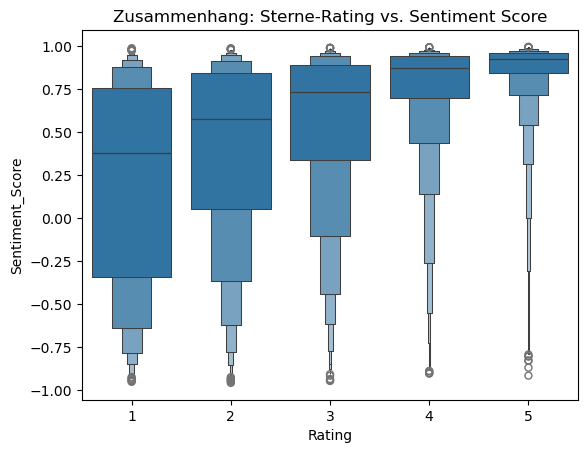

In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Wir erstellen eine Funktion, die den "Compound Score" (-1 bis 1) extrahiert
df['Sentiment_Score'] = df['Review Text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Schauen wir uns an, ob Sentiment und Rating zusammenpassen
sns.boxenplot(x='Rating', y='Sentiment_Score', data=df)
plt.title('Zusammenhang: Sterne-Rating vs. Sentiment Score')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Wir erstellen ein paar zusätzliche Features aus dem Text
df['Review_Length'] = df['Review Text'].apply(len)

# Features (X) und Zielvariable (y) definieren
# Wir nehmen Sentiment, Alter und Review-Länge als Input
X = df[['Sentiment_Score', 'Age', 'Review_Length']]
y = df['Recommended IND']

# Train-Test-Split (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Modell initialisieren und fitten
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred = rf_model.predict(X_test)

# Ergebnisse checken
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.33      0.40       812
           1       0.86      0.93      0.90      3717

    accuracy                           0.82      4529
   macro avg       0.69      0.63      0.65      4529
weighted avg       0.80      0.82      0.81      4529



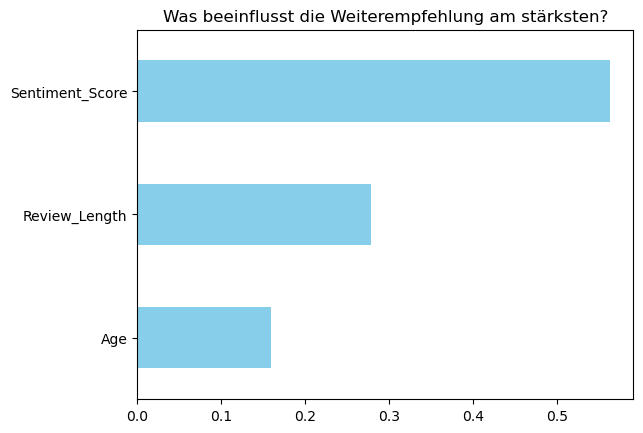

In [11]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Was beeinflusst die Weiterempfehlung am stärksten?')
plt.show()

In [12]:
# Wir erstellen ein DataFrame für den Vergleich
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred
results['Review_Text'] = df.loc[X_test.index, 'Review Text']

# Wir suchen nach "False Positives": Modell sagt "Empfohlen" (1), aber Actual ist "Nicht empfohlen" (0)
false_positives = results[(results['Actual'] == 0) & (results['Predicted'] == 1)]

print(f"Anzahl der False Positives: {len(false_positives)}")
print("-" * 30)
print("Beispiel für einen kritischen Fehler:")
print(false_positives['Review_Text'].iloc[0][:200] + "...") # Zeigt die ersten 200 Zeichen

Anzahl der False Positives: 547
------------------------------
Beispiel für einen kritischen Fehler:
On the hanger, this looks like a great lbd. on me, not quite. the bell shape of this dress made it appear that i was carrying extra weight in the middle.  for reference, i tried a 0p, and i'm 5,1", 10...
